In [173]:
from __future__ import division

import matplotlib.pyplot as plt
%matplotlib inline

import numpy as np
import pandas as pd

### Helper Functions

In [2]:
def simulate_single_random_walk():
    '''
    Runs a sinlge random walk starting in the middle of range(0,4).
    If the current_state goes outside this range, the random walk ends.
    INPUT
        NONE
    OUTPUT 
        outcome: Integer. 0 or 1. 0 if the agent fell out the left side of the
            bounds. 1 if the agent fell outside of the right side of the bounds.
        path: list of integers. The indices that the agent covered in the random walk.
    '''
    boundaries = [0,4]
    moves = [-1, 1]
    current_state = 2
    path = []
    
    # while x is within the bounds
    while current_state >= boundaries[0] and current_state <= boundaries[1]:
        path.append(current_state)
        move = np.random.choice(moves)
        current_state += move
        
    if current_state < 0:
        return 0, path
    else:
        return 1, path

In [56]:
def rmse(predictions, targets):
    return np.sqrt(((predictions - targets) ** 2).mean())

### Version 0: Attempt to Follow Paper

In [233]:
def w_update(lam, alpha, P_t_1, P_t_0, e_t):
    # e_t update per page 16 of Learning to Predict by Methods of Temporal Difference
    delta_w_t = alpha * (P_t_1 - P_t_0) * (lam * e_t + P_t_1) 
    return delta_w_t

def convergence_simulator(alpha, lam):
    states = [np.zeros(5) for _ in range(5)]
    for idx, state in enumerate(states):
        state[idx] = 1.0
    w = np.array([.5, .5, .5, .5, .5])
    actual_probs = np.array([1/6, 1/3, 1/2, 2/3, 5/6])
    rmse_list = []
    
    for training_set in range(100):
        # paths will be a list of lists. Each sublist will be a path walked
        paths = []
        outcomes = []
        for sequence in range(10):
            outcome, path = simulate_single_random_walk()
            outcomes.append(outcome)
            paths.append(path)
            
        iter_count = 0
        sigma = .01
        iteration_delta = 100
        while iteration_delta > sigma and iter_count < 1000:
            
            iter_count += 1
            if iter_count > 999:
                break
                
            for path, outcome in zip(paths, outcomes):
                original_w = w.copy()
                for idx in range(len(path) - 1):
                    if idx == 0:
                        e_t = path[0]
                    t = idx + 1
                    P_t_1 = states[path[idx + 1]]
                    P_t_0 = states[path[idx]]
                    w += w_update(lam, alpha, P_t_1, P_t_0, e_t)
                iteration_delta = np.linalg.norm(w - original_w)
                
        rmse_estimate = rmse(w, actual_probs)
        rmse_list.append(rmse_estimate)
        
    return np.average(rmse_estimate)           

In [234]:
convergence_simulator(alpha=.035, lam=0)

58560.282349341847

### Version 1: Attempt to follow Slide Format

In [219]:
def get_delta_V(V, state_one, state_zero, alpha, reward, e, lam):
    delta_V = alpha * (reward + V[state_one] - V[state_zero]) * e
    return delta_V

def simulate_multiple_walks(alpha=0.3, lam=0):
    '''
    Runs multiple random walks and updates expected values (w vector) according
    to TD(lambda) formula (4).
    INPUT
        alpha: float between 0 and 1. Learning rate.
        lam: float between 0 and 1. Lambda value.
    OUTPUT
        RMS: float between 0 and 1. Root Mean Squared Error.
    '''
    V = np.array([0.5, 0.5, 0.5, 0.5, 0.5])
    actual_probs = np.array([1/6, 1/3, 1/2, 2/3, 5/6])
    rmse_values = []
    
    for training_set in range(100):
        V_updates = []
        for episode in range(10):
            current_V = V.copy()
            e = np.zeros(5)
            walk_outcome, path = simulate_single_random_walk()
            for idx in range(len(path) - 1):
                if idx == range(len(path) - 1)[-1]:
                    reward = walk_outcome
                else:
                    reward = 0
                state_zero = path[idx]
                state_one = path[idx + 1]
                e[state_zero] += 1
                delta_V = get_delta_V(current_V, state_one, state_zero, alpha, reward, e, lam)
                current_V += delta_V
                V_updates.append(delta_V)
                e *= lam
        for delta_v in V_updates:
            V += delta_v
        rmse_values.append(rmse(V, actual_probs))
        
    return np.average(rmse_values)

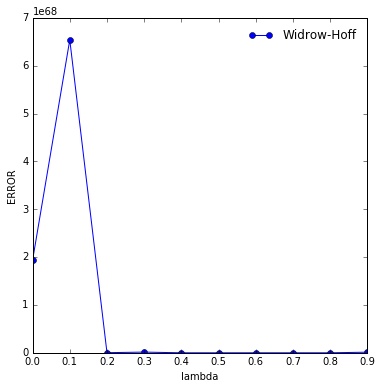

In [221]:
rmse_vals = []
lam_vals = np.arange(0,1.1, 0.1)
for lam_val in lam_vals:
    rmse_vals.append(simulate_multiple_walks(alpha=0.3, lam=lam_val))
    
plt.rcParams['figure.figsize'] = (6, 6)
plt.plot(lam_vals, rmse_vals, 'o-', label="Widrow-Hoff")
plt.legend(frameon=False, loc='best')
plt.ylabel("ERROR")
plt.xlabel("lambda")
plt.xticks(lam_vals)
plt.show()

### Version 2: Github Repo Version

In [58]:
def calculate_delta(reward, state_one, state_zero, V, alpha):
    delta = reward + V[state_one] - V[state_zero]
    return delta

def update_values(state_one, state_zero, reward, V, e, lam, alpha):
    delta = calculate_delta(reward, state_one, state_zero, V, alpha)
    e[state_zero] += 1.0
    V += alpha * delta * e
    e *= lam
    return V, e
    
def simulate_td_lambda(alpha=.035, lam=0):
    V = np.array([0.5, 0.5, 0.5, 0.5, 0.5])
    actual_probs = np.array([1/6, 1/3, 1/2, 2/3, 5/6])
    
    for i in range(1000):
        e = np.zeros(5)
        outcome, path = simulate_single_random_walk()
        for state_zero, state_one in zip(path[:-1], path[1:]):
            V, e = update_values(state_one, state_zero, reward, V, e, lam, alpha)
    
    print "Actual Probs: ", actual_probs
    print "Predicted Probs: ", V
    error = rmse(V, actual_probs)
    return error

In [60]:
error = simulate_td_lambda(alpha=.35, lam=0)
print error

Actual Probs:  [ 0.16666667  0.33333333  0.5         0.66666667  0.83333333]
Predicted Probs:  [ 19.36574944  19.39611468  19.55511503  19.73102528  19.66128945]
19.0422347503


### Widrow-Hoff Implementation
This implementation is in accordance with the method described in the paper.
This doesn't work because the gradient is always [0,0,0,0,0] so it never moves.

In [86]:
################ Initial Variables #######################
states = [np.zeros(5) for _ in range(5)]
for idx, state in enumerate(states):
    state[idx] = 1.0

    
def get_delta_w(w, P_one, P_zero, lam, alpha, e_t):
    alpha_term = alpha * (P_one - P_zero)
    e_t_plus_one = outcome * P_one * lam * e_t
    delta_w = e_t_plus_one * alpha_term
    return e_t_plus_one, delta_w

def simulate_wf_random_walks(alpha=.35, lam=.3):
    w = np.array([0.5, 0.5, 0.5, 0.5, 0.5])
    actual_probs = np.array([1/6, 1/3, 1/2, 2/3, 5/6]) 
    
    for _ in range(100):
        training_set = []
        for seq in range(10):
            outcome, path = simulate_single_random_walk() 
            learning_sequence = [states[idx] for idx in path]
            e_t = w * learning_sequence[0]
            for state_zero, state_one in zip(learning_sequence[:-1], learning_sequence[1:]):
                P_zero = np.dot(w, state_zero)
                P_one = np.dot(w, state_one)
                e_t, delta_w = get_delta_w(w, P_one, P_zero, lam, alpha, e_t)
                training_set.append(delta_w)
        w += np.sum(training_set, axis=0)
        error = rmse(w, actual_probs)
   
    print error
    print w
    print training_set

### Reinforcement Learning: An Introduction, Book Implementation
This is in accordance with section 6.1 of Sutton and Barto's textbook.

In [102]:
def get_val(current_state, next_state, V, alpha):
    if next_state <= 4:
        V[current_state] = (
            V[current_state] + alpha * (0 + V[next_state] - V[current_state])
        )
    else:
        V[current_state] = V[current_state] + alpha * (1 - V[current_state])
    
    return V
    

def s_and_b_random_walk(lam=0, alpha=.35, num_episodes=100):
    V = np.array([.5, .5, .5, .5, .5])
    states = [0,1,2,3,4,5]
    for _ in range(num_episodes):
        current_state = 2
        while current_state >= 0 and current_state <= 4:
            action = np.random.choice([-1,1])
            next_state = current_state + action
            V = get_val(current_state, next_state, V, alpha)
            current_state = next_state
    
    return V

In [104]:
s_and_b_random_walk(lam=0, alpha=.35, num_episodes=1000)

array([ 1.,  1.,  1.,  1.,  1.])